In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import importlib as il

base_pth, code_pth, data_pth, _, fig_pth = can.utils.setup_paths(make_missing=False)
plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
cmax = 50

JG069J = (
    QuantStudio(data_pth / 'JG069J Final TB Experiment.xlsx', 'JG069J')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax, method='min-max')
    .invert_fluorophore('HEX')
)

JG069J.reactions.wide = (JG069J.reactions.wide
                         .drop(columns=['Sample'])
                         .merge(pd.read_csv(data_pth / 'JG069J Plate Map.csv'), on='Well')
                        )

In [3]:
JG069J.reactions.neaten()
JG069J.extract_endpoints(cmax=cmax, name='FAM-HEX', method='diff')
endpoints = JG069J.endpoints

# endpoints = endpoints[
#     ~((endpoints.PRDM1==5) & (endpoints.ARG1==2))
# ]

In [4]:
gp_config = {
    'continuous_dims': ['GBP6', 'ARG1', 'TMCC1', 'PRDM1'],
    #'linear_dims': ['GBP6', 'ARG1', 'TMCC1', 'PRDM1']
}

ds = gmb.DataSet(endpoints, outputs=['FAM-HEX'])
gp = gmb.GP(ds).fit(**gp_config)

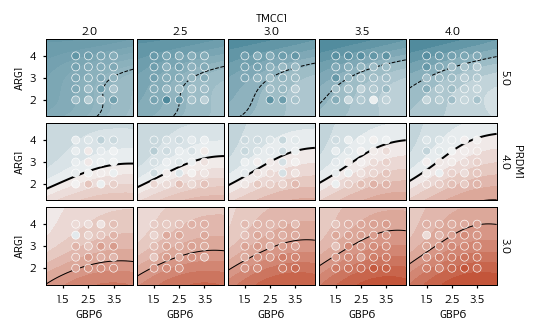

In [5]:
import warnings

width = 3.65
height = 2.187
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

mar_l = 0.30  # 0.237
mar_r = 0.22
mar_t = 0.22
mar_b = 0.26

hue = 'FAM-HEX'
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

g = sns.relplot(data=endpoints, col="TMCC1", row ="PRDM1",
                x = 'GBP6', y='ARG1',
                hue=hue, hue_norm=norm,
                row_order=[5.0, 4.0, 3.0],
                palette=cmap, legend=False,
                kind='scatter', 
                # height=fig_size[1]/4, aspect=(fig_size[0]/6)/(fig_size[1]/4),
                s=4**2, zorder=10,
                facet_kws={
                    'margin_titles': False,
                    'despine': False,
                    })

fig = plt.gcf()
fig.set_size_inches(figsize)

for (prdm1, tmcc1), ax in g.axes_dict.items():
    ax.tick_params(axis='both', labelsize=ticklabelsize)
    ax.set_title('', fontsize=labelsize)
    if prdm1==5.0:
        ax.set_title(f'{tmcc1:.1f}', fontsize=labelsize, pad=2)
        if tmcc1==3.0:
            ax.set_title(f'TMCC1\n{tmcc1:.1f}', fontsize=labelsize, pad=2)
    if tmcc1==4.0:
        ax2 = ax.twinx()
        ax2.set_ylabel(f'{prdm1:.1f}', va='bottom', fontsize=labelsize, rotation=270, labelpad=1)
        if prdm1==4.0:
            ax2.set_ylabel(f'PRDM1\n{prdm1:.1f}', va='bottom', fontsize=labelsize, rotation=270, labelpad=1)
        ax2.set_yticks([])
    else:
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=2)
        
        
        
    if prdm1 != 3.0:
        ax.xaxis.set_tick_params(length=0)
    else:
        ax.xaxis.set_tick_params(length=1.5, width=0.6)
        
    if tmcc1 != 2.0:
        ax.yaxis.set_tick_params(length=0)
    else:
        ax.yaxis.set_tick_params(length=1.5, width=0.6)
        
    ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
    ax.set_xticks([1.5, 2.5, 3.5])
    ax.set_yticks([2, 3, 4])
    
    at = gp.parray(PRDM1=prdm1, TMCC1=tmcc1)
    XY = gp.prepare_grid(at=at)
    sig = gp.predict_grid()
    
    plt.sca(ax)
    pp = gmb.ParrayPlotter(x=XY['GBP6'], y=XY['ARG1'], z=sig)
    pp(plt.contourf, cmap=cmap, norm=norm, zorder=-10)
#     pp.colorbar(ax=ax)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pp(plt.contour, levels=[-0.5, +0.5], linewidths=0.5, colors='k', norm=norm, zorder=-5)
        pp(plt.contour, levels=[0.], linewidths=1, colors='k', norm=norm, zorder=-5)
        
plt.subplots_adjust(
    left=0.065, 
    right=0.94, 
    top=0.9, 
    bottom=0.12
)
        
plt.subplots_adjust(
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
)

plt.savefig(fig_pth / 'JG069J 4D surface.png', dpi=600, transparent=True);

# can.utils.savefig('JG069J Response Surfaces', path=fig_pth)

In [6]:
limits = gp.parray(
    GBP6=[endpoints.GBP6.min(), endpoints.GBP6.max()],
    ARG1=[endpoints.ARG1.min(), endpoints.ARG1.max()],
    TMCC1=[endpoints.TMCC1.min(), endpoints.TMCC1.max()],
    PRDM1=[endpoints.PRDM1.min(), endpoints.PRDM1.max()],
)

GATP = gp.prepare_grid(limits=limits, resolution=10)
sig = gp.predict_grid()

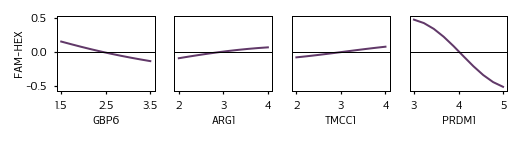

In [7]:
width = 3.65
height = 0.829
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

mar_l = 0.30
mar_r = 0.22
mar_t = 0.04
mar_b = 0.27

axs = plt.subplots(1, 4, figsize=figsize, sharey=True)[1]

for i, (name, ax) in enumerate(zip(GATP.names, axs)):
    plt.sca(ax)
    x = gp.grid_vectors[name].flatten()
    dims = tuple([j for j in range(len(GATP.names)) if j!=i])
    gmb.ParrayPlotter(x, sig.mean(axis=dims)).plot(line_kws={'lw':1})
        
    ax.axhline(0, color='k', lw=0.5)
    ax.tick_params(axis='both', labelsize=ticklabelsize, length=1.5, width=0.6)
    ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
    ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
    
    if i>0:
        ax.set_ylabel('')
        ax.yaxis.set_tick_params(length=0)
    
    xticks = {
        'GBP6': [1.5, 2.5, 3.5],
        'ARG1': [2, 3, 4],
        'TMCC1': [2, 3, 4],
        'PRDM1': [3, 4, 5],
    }[name]
    
    ax.set_xticks(xticks)
        
plt.subplots_adjust(
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
)

plt.savefig(fig_pth / 'JG069J 4D marginals.png', dpi=600, transparent=True);
# can.utils.savefig('JG069J Marginal Response Surfaces', path=fig_pth)